In [1]:
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
#mpl.rcParams['image.cmap'] = 'jet'

# general
import numpy as np
import time, sys

# slide stuff
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/rgast/anaconda3/envs/mne/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "simple",
              "transition": "zoom",
              "start_slideshow_at": "selected",
})

{'start_slideshow_at': 'selected', 'theme': 'simple', 'transition': 'zoom'}

<center><font color="blue">IMPRS NeuroCom basic course on EEG/MEG </font>
-----------------------------------------------------------------------
<br><center>
    
O. David & K.J. Friston (2003) <br/> "A Neural mass model for MEG/EEG: Coupling and neuronal dynamics"
=======================================================

<br><center>
*<font color="blue">Presented and replicated by Richard Gast using PyRates</font>*

<center>Overview
----------------

**<font color="blue">1. Introduction to the paper**
    - EEG/MEG signal generation background
    - Research questions
**<font color="blue">2. The neural mass model (NMM)**
    - What is a neural mass
    - Jansen-Rit NMM: A forward model of the EEG/MEG signal
**<font color="blue">3. The dynamical behavior of (coupled) NMMs**
    - Spectral response of single Jansen-Rit NMM
    - Generalized Jansen-Rit NMM
    - Coupled NMMs
**<font color="blue">4. Discussion**


<img src="img/David_EEGsignal_origin.png",width=600,height=400, ALIGN="right">

<font color="blue">1. Introduction to the paper
-----------------------------------------------

**The origin of EEG/MEG signals:**

* Mainly result from extracellular current flow

* Currents arise from large number of cells aligned in parallel that are synchronously de- or hyperpolarized

* Typically, EEG/MEG signals can be decomposed into distinct frequency bands which appear to be correlated with certain cognitive states

<img src="img/David_EEGspectra.png",width=600,height=400, ALIGN="right">

**Research Questions**

* Can the Jansen-Rit NMM reproduce the major frequency bands (delta, theta, alpha, beta, gamma) observed in the EEG/MEG signal? <br/><br/>

* How can the Jansen-Rit model relate spectral changes to alterations in structural connectivity? <br/>

<font color="blue">2. The neural mass model (NMM)
-------------------------------------------------

* Described in detail by Jansen & Rit (1995)
* Mesoscopic description of interactions between large (homogeneous) neural populations, i.e. neural masses

<img src="img/JR_circuit_reduced.png" width=400 ALIGN="left" style="margin: 0px 200px">

<br></br><br></br>
PC = Pyramidal Cells <br></br>
EIN = Excitatory Interneurons <br></br>
IIN = Inhibitory Interneurons

**What is a neural mass?**

* A neural mass is a mean-field description of the average behavior of a large, homogeneous cell population.
* This mean-field description includes two major state variables:

    <font color="red">1. Average membrane potential <br>
    <font color="green">2. Average firing rate generated at the axon hillock <br/><br/>

**What is a neural mass?**

* A neural mass is a mean-field description of the average behavior of a large, homogeneous cell population.
* This mean-field description includes two major state variables:

    <font color="red">1. Average membrane potential<br></font>
    <font color="green">2. Average firing rate generated at the axon hillock </font><br/><br/>

* To arrive at <font color="red">1</font>, a mean-field approximation of the sub-threshold dynamics of the leaky integrate-and-fire neuron is used.

**What is a neural mass?**

* Assuming a large enough cell population that receives similar synaptic input that varies slower than the synaptic kinetics of that population, the <font color="red">average membrane potential</font> is described by:

$$v(t) = \int_{t' = -\infty}^{t} h_{e/i}(t - t') \times p(t') dt'$$

<br/><center>
$v = $  average post-synaptic membrane potential <br/>
$h_{e/i} = $ excitatory or inhibitory synaptic kernel (see below) <br/>
$p = $ incoming pre-synaptic average firing-rate <br/>
</center>

$$v(t) = \int_{t' = -\infty}^{t} h_{e/i}(t - t') \otimes p(t') dt'$$

<br/><center>
$v = $  average post-synaptic membrane potential <br/>
$h_{e/i} = $ excitatory or inhibitory synaptic kernel (see below) <br/>
$p = $ incoming pre-synaptic average firing-rate <br/>
</center>

*Synaptic kernel:*

$$h_{e/i}(t) = \frac{H_{e/i} t \exp(\frac{-t}{\tau_{e/i}})}{\tau_{e/i}}$$

<br/><center>
$H_{e/i} = $ efficacy of excitatory/inhibitory synapse (negative for inhibitory ones) <br/>
$\tau_{e/i} = $ lumped time constant of excitatory/inhibitory synapse
</center>

Text(0,0.5,'membrane potential [V]')

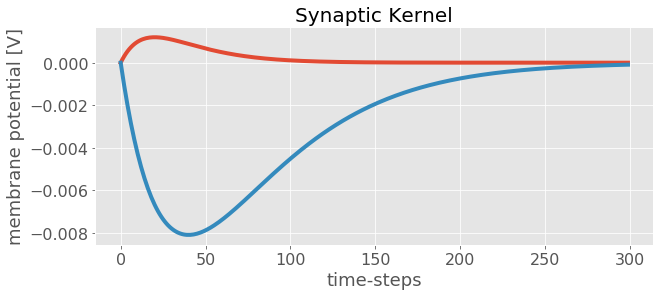

In [3]:
from core.synapse import JansenRitExcitatorySynapse, JansenRitInhibitorySynapse
from core.synapse import AMPACurrentSynapse, GABAACurrentSynapse, GABABCurrentSynapse

# instantiate an excitatory and an inhibitory synapse
synapse_e = JansenRitExcitatorySynapse(bin_size=5e-4, max_delay=0.15)
synapse_i = JansenRitInhibitorySynapse(bin_size=5e-4, max_delay=0.15)

# plot synaptic kernels
fig, axes = plt.subplots(figsize=(10,4))
axes = synapse_e.plot_synaptic_kernel(create_plot=False, axes=axes)
axes = synapse_i.plot_synaptic_kernel(create_plot=False, axes=axes)
axes.set_ylabel('membrane potential [V]')

* Mean-field description of a neural mass includes two major state variables:

    <font color="red">1. Average membrane potential</font><br>
    <font color="green">2. Average firing rate generated at the axon hillock</font> <br/><br/>

* To arrive at <font color="green">2</font>, a simple sigmoidal transform is used:

$$p(t) = \frac{2e_0}{1 + \exp(r(v_0 - v(t)))}$$

<br/><center>
$e_0 = $ half of the maximum firing rate <br/>
$r = $ steepness of the sigmoid <br/>
$v_0 = $ membrane potential threshold. If $v = v_0$, $p(t) = e_0$ 
</center>

Default maximum firing rate (2*e0):  5.0  Hz.
Default membrane potential threshold (v0):  0.006  V.
Default sigmoid steepness (r):  560.0  Hz.


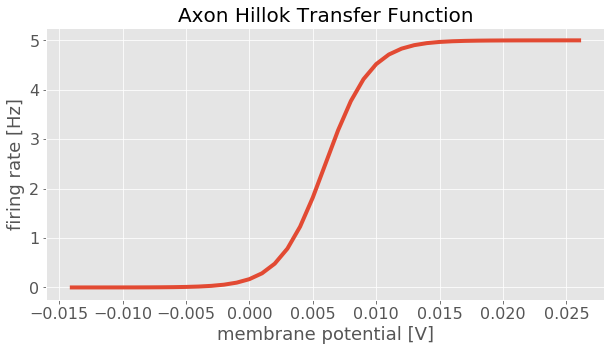

In [8]:
from core.axon import JansenRitAxon

# initialize axon
axon = JansenRitAxon()

# plot axon
fig, axes = plt.subplots(figsize=(10, 5))
axes = axon.plot_transfer_function(create_plot=False, axes=axes)

**A forward model of the EEG/MEG signal (Jansen & Rit, 1995)**

<img src="img/JR_circuit_original.png",width=500,height=500>


In [9]:
from core.circuit import JansenRitCircuit

# instantiate circuit
c = 135.
step_size = 1e-4
circuit = JansenRitCircuit(step_size=step_size, max_synaptic_delay=1.0, connectivity_scaling=c)

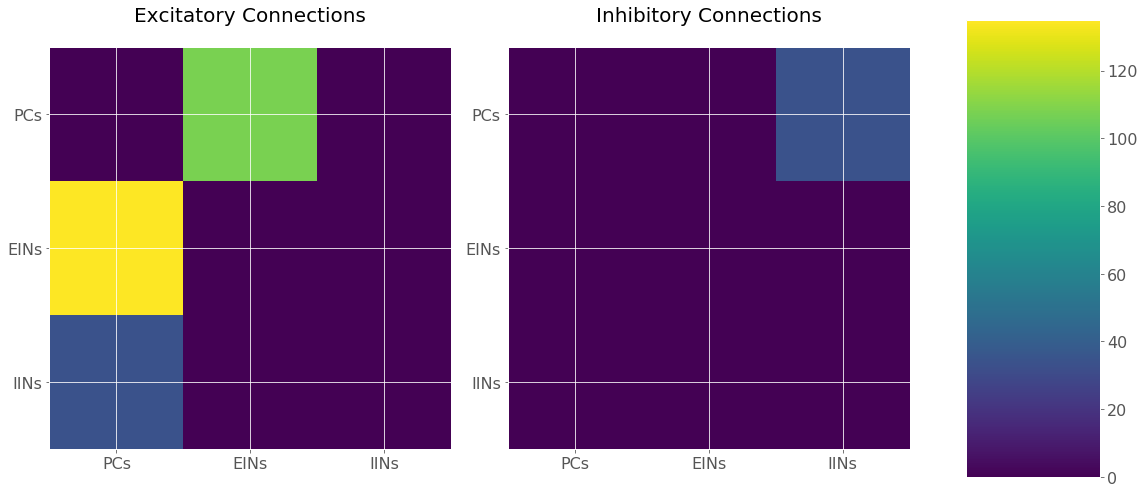

In [6]:
# plot circuit connectivity
fig2, axes = plt.subplots(1,3, figsize=(16,7), gridspec_kw = {'width_ratios':[3, 3, 1]})
ax1 = axes[0]
m = ax1.matshow(np.squeeze(circuit.C[:, :, 0]), clim=[0, c])
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xticklabels(['', 'PCs', 'EINs', 'IINs'])
ax1.set_yticklabels(['', 'PCs', 'EINs', 'IINs'])
ax1.set_title('Excitatory Connections')
ax2 = axes[1]
ax2.matshow(np.squeeze(circuit.C[:, :, 1]), clim=[0, c])
ax2.xaxis.set_ticks_position('bottom')
ax2.set_xticklabels(['', 'PCs', 'EINs', 'IINs'])
ax2.set_yticklabels(['', 'PCs', 'EINs', 'IINs'])
ax2.set_title('Inhibitory Connections')
ax3 = axes[2]
fig2.colorbar(m, cax=ax3, orientation='vertical')
plt.tight_layout()

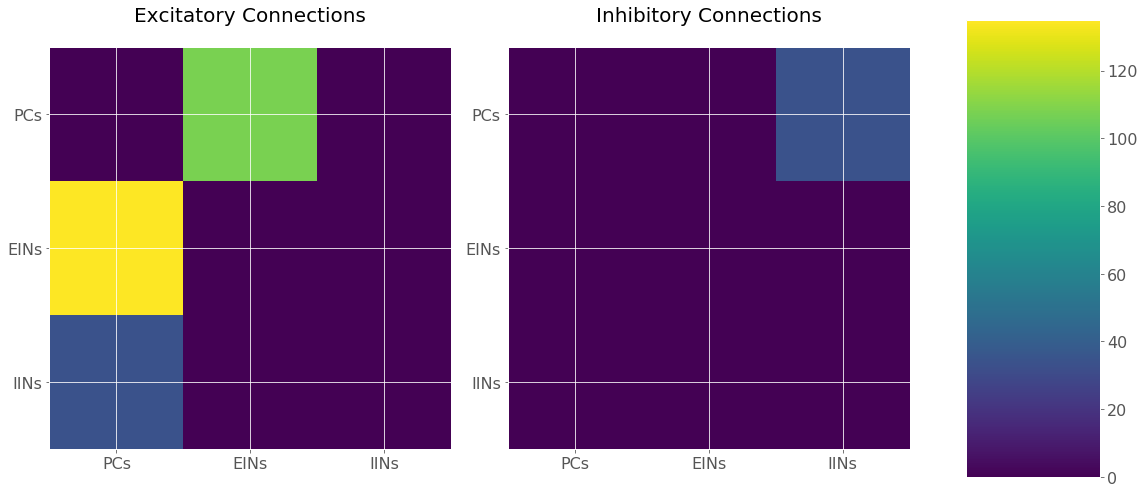

In [10]:
fig2

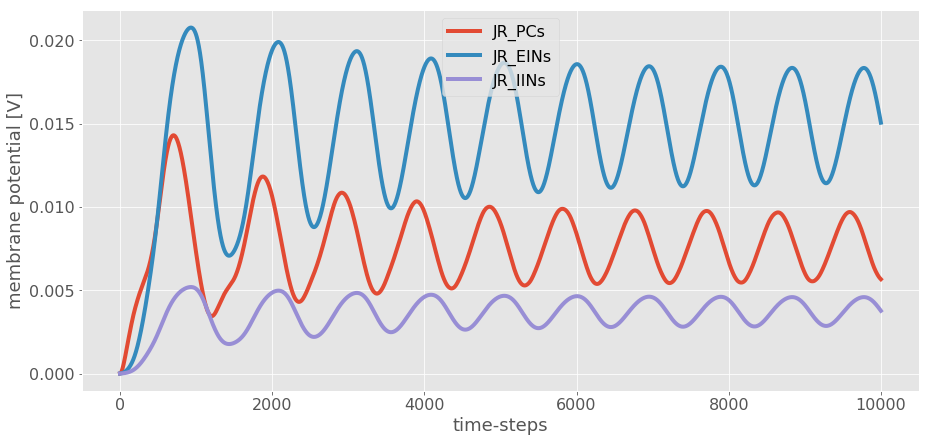

In [11]:
# define input to circuit
simulation_time = 1.                                                    # 1 s simulation duration
simulation_steps = int(simulation_time / step_size)

synaptic_input = np.zeros((simulation_steps, 3, 2))                     # time-steps x 3 populations x 2 synapses
synaptic_input[:, 0, 0] = 22 * np.random.randn(simulation_steps) + 220  # gaussian input to PCs

# simulate circuit behavior
circuit.run(simulation_time=simulation_time, synaptic_inputs=synaptic_input)

# plot membrane potential traces
fig, axes = plt.subplots(figsize=(15,7))
axes = circuit.plot_population_states(create_plot=False, axes=axes)

<font color="blue">3. The dynamic behavior of (coupled) NMMs
------------------------------------------------------------
<br>
**Investigation of the spectral responses of a single Jansen-Rit NMM**

* systematic variation of synaptic time constants tau (2, 4, 6, ..., 60 ms)
* re-scaling of synaptic efficacies to keep H_e/i * tau_e/i constant
* Stochastic Gaussian input (mean = 220 Hz, var = 22 Hz) delivered to PCs over simulation period

*Simulation results:*

<img src="img/David_singleNMM_spectrogram.png",width=1400,height=1100>

*Replication of the exemplary PC membrane potential traces:*

In [12]:
# circuit parameters
step_size = 1e-3
max_delay = 0.7
n_populations = 3
n_synapses = 2
synapse_params = [dict(), dict()]

# simulation parameters
simulation_time = 2.0                                                     
cutoff_time = 1.0
time_steps = int(simulation_time / step_size)
cutoff_steps = int(cutoff_time / step_size)

# define synaptic input (includes initial condition)
synaptic_input = np.zeros((time_steps, n_populations, n_synapses))
synaptic_input[:, 0, 0] = 22. * np.random.randn(time_steps) + 220.

In [13]:
# define experimental conditions
tau_e = np.array([4.0, 49.9, 28.0, 17.5, 10.0, 4.6]) * 1e-3  # unit: s
tau_i = np.array([26.7, 48.1, 30.9, 14.3, 6.1, 2.9]) * 1e-3  # unit: s

In [17]:
# perform experiment for each condition
pc_state_coll = list()                                              # used to collect the membrane potential of the PCs

for t_e, t_i in zip(tau_e, tau_i):
    
    # set experimental condition
    synapse_params[0]['tau'] = t_e
    synapse_params[1]['tau'] = t_i
    
    synapse_params[0]['efficacy'] = 3.25e-3 * (10e-3 / t_e)
    synapse_params[1]['efficacy'] = -22e-3 * (20e-3 / t_i)

    # instantiate circuit
    circuit = JansenRitCircuit(step_size=step_size,
                               connectivity_scaling=c,
                               synapse_params=synapse_params,
                               max_synaptic_delay=max_delay)

    # perform experiment
    circuit.run(synaptic_inputs=synaptic_input, simulation_time=simulation_time)

    # collect PC membrane potentials
    pc_state_coll.append(np.squeeze(circuit.get_population_states(0, [0], time_window=[cutoff_time, simulation_time])))
    
print('Simulations done!')

Simulations done!


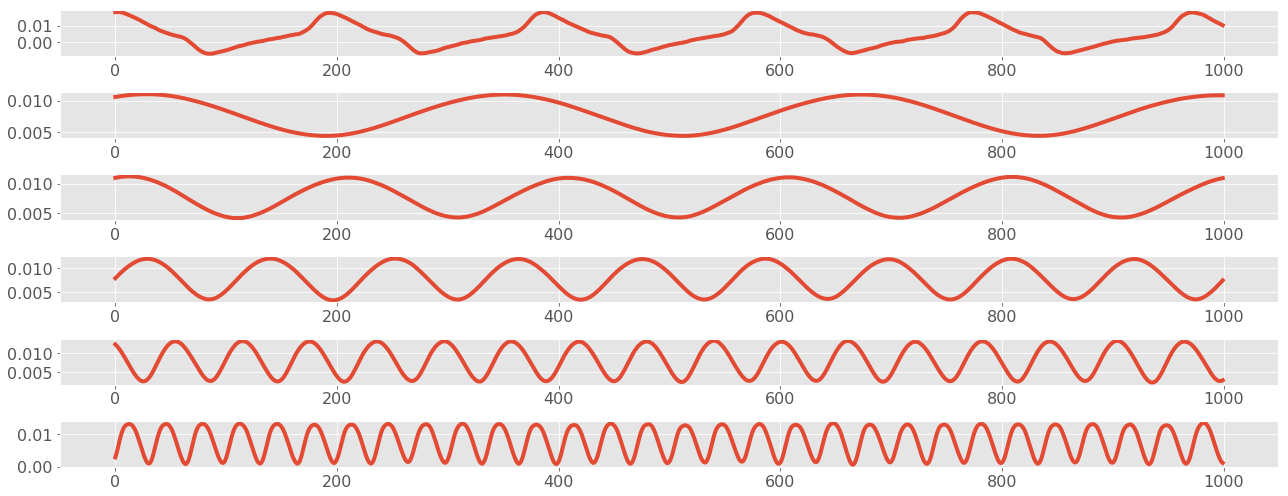

In [18]:
# plot results
fig, axes = plt.subplots(len(pc_state_coll), 1, figsize=(18, 7))
for i in range(len(pc_state_coll)):
    axes[i].plot(pc_state_coll[i])
plt.tight_layout()

<img src="img/David_gJRC.png",width=500,height=500, ALIGN="right">

**Oscillations in the generalized Jansen model**

*Generalized Jansen-Rit model:*

<img src="img/David_generalizedJR_structure.png",width=800,height=800, ALIGN="left">

*Experiment:*

* Use generalized Jansen-Rit circuit with PCs, EINs and IINs split into 2 subpopulations
* one subpopulation with synaptic kinetics typically producing alpha and one producing gamma oscillations
* systematic variation over the weighting between alpha and gamma populations

*Simulation results:*

<img src="img/David_generalizedJR_dynamics.png" width=1000 height=1200>

*PyRates replication:*

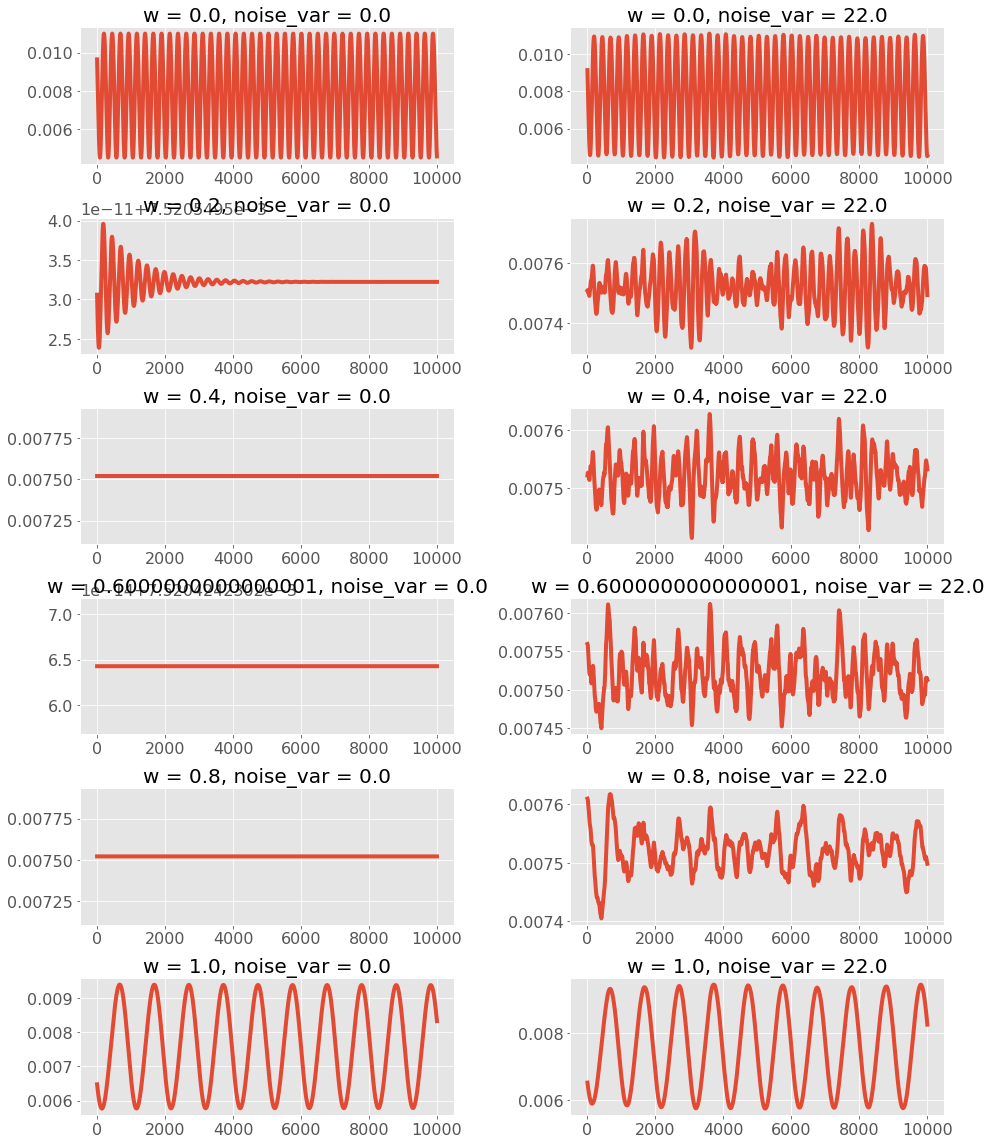

In [2]:
from core.circuit import GeneralizedJansenRitCircuit

# general parameters
####################

step_size = 1e-4
max_synaptic_delay = 1.0
simulation_time = 3.
simulation_steps = int(simulation_time / step_size)
cutoff_time = 2.
cutoff_steps = int(cutoff_time / step_size)

# define parametrizations of sub-circuits
#########################################

# connectivity
cs = [135., 135.]

# synaptic alpha kinetics
tau_e_1 = 10.8e-3
tau_i_1 = 22e-3
H_e_1 = 3.25e-3 * 10e-3 / tau_e_1
H_i_1 = -22e-3 * 20e-3 / tau_i_1
synapse_params_alpha = [{'tau': tau_e_1, 'efficacy': H_e_1}, {'tau': tau_i_1, 'efficacy': H_i_1}]

# synaptic gamma kinetics
tau_e_2 = 4.6e-3
tau_i_2 = 2.9e-3
H_e_2 = 3.25e-3 * 10e-3 / tau_e_2
H_i_2 = -22e-3 * 20e-3 / tau_i_2
synapse_params_gamma = [{'tau': tau_e_2, 'efficacy': H_e_2}, {'tau': tau_i_2, 'efficacy': H_i_2}]

synapse_params = [synapse_params_alpha, synapse_params_gamma]

# define experimental conditions
################################

weights = np.arange(0., 1.1, 0.2)
noise_var = [0., 22.]
noise_mean = 220.
synaptic_input = np.zeros((simulation_steps, 6, 2))
gaussian_noise = np.random.randn(simulation_steps)

# perform experiment and plot results
#####################################

# create results figure
fig, axes = plt.subplots(6, 2, figsize=(14, 16))

for i, w in enumerate(weights):
    
    for j, var in enumerate(noise_var):

        # define input
        synaptic_input[:, 0, 0] = var * gaussian_noise + noise_mean
        synaptic_input[:, 3, 0] = var * gaussian_noise + noise_mean
        
        # instantiate circuit
        gjrc = GeneralizedJansenRitCircuit(n_circuits=2, step_size=step_size, max_synaptic_delay=max_synaptic_delay,
                                           synapse_params=synapse_params, connectivity_scalings=cs,
                                           weights=[w, 1-w])

        # simulate behavior
        gjrc.run(synaptic_input, simulation_time)
        
        # collect states and apply weights
        states = gjrc.get_population_states(0, [0, 3], time_window=[cutoff_time, simulation_time])
        states = w * states[:, 0] + (1-w) * states[:, 1]
        
        # plot pc traces
        ax = axes[i, j]
        ax.plot(states)
        ax.set_title('w = ' + str(w) + ', noise_var = ' + str(var))
        
plt.tight_layout()

**A coupling model for interacting cortical columns**

<img src="img/David_coupling.png" width=1200 height=800>

*Behavior of two coupled generalized Jansen-Rit NMMs:*

<img src="img/David_coupling_results.png",width=1000,height=800>

<font color="blue">4. Discussion
--------------------------------

<sub>* What do you think of the assumption that the EEG/MEG spectrum is the result of distinct neural circuits with specific synaptic kinetics interacting with each other?<sub>


<sub>* What do you think of the coupling model proposed here, modeling the influence strength of a source area on a target area as the proportion of the target's input variance that the source area is responsible for?<sub>

<sub>* The here described Jansen-Rit NMM is a fundamental part of the current DCM framework, providing one of the local neurodynamic models used to make inferences about structural connections between brain areas etc - how does that limit the applicability/interpretability of DCM analyses?<sub>

In [10]:
from models.BGTC import Thalamus

th = Thalamus()

AttributeError: Invalid synapse type!